## Set-Up

In [192]:
# Imports
import sys
import os
import re
from os.path  import join, isfile
from os import listdir
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from functions import vanilla_score
from sklearn.metrics import accuracy_score
import numpy as np
from statsmodels.stats.inter_rater import fleiss_kappa, aggregate_raters
import krippendorff
from krippendorff import alpha
from bootstrap_alpha import bootstrap
from functions import kippendorff_analysis
import matplotlib.pyplot as plt
%matplotlib inline

In [193]:
# Functions
def extract_info(name):
    pattern = r"(?P<type>\w+)_(?P<model>\w+)_(?P<temperature>\d+)"
    match = re.match(pattern, name)
    if match:
        info = match.groupdict()
        info['temperature'] = float(info['temperature'])  # Convert temperature to float
        return info
    else:
        raise ValueError(f"Name '{name}' does not match the expected pattern")

def process_names(names): # extract infos from evaluator name
    extracted_info = {}
    for name in names:
        try:
            info = extract_info(name)
            extracted_info[name] = info
        except ValueError as e:
            print(e)
    return extracted_info

def add_details(info_dict, details):
    for name, info in info_dict.items():
        model = info['model']
        if model in details:
            info_dict[name]['specific_model_name'] = details[model]['specific_model_name']
            info_dict[name]['introduction_date'] = details[model]['introduction_date']
    return info_dict

def filter_names(info_dict, model_type=None, model=None, temperature=None, specific_model_name=None, introduction_date=None): # filter evaluators based on criteria in dict
    filtered_names = []
    for name, info in info_dict.items():
        if (model_type is None or info['type'] == model_type) and \
           (model is None or info['model'] == model) and \
           (temperature is None or int(info['temperature']) == temperature) and \
           (specific_model_name is None or info.get('specific_model_name') == specific_model_name) and \
           (introduction_date is None or info.get('introduction_date') == introduction_date):
            filtered_names.append(name)
    return filtered_names

def agreement_table(evaluator): # transform evaluator_scores into agreement table
    data = globals()[evaluator + '_scores'] 
    cols = data.index # save text numbers as column names for later
    data = data.transpose() # transpose scores
    data.columns = cols # rename columns
    data = data[1:].apply(pd.to_numeric) # convert to numeric

    # transform scores to agreement table ##TODO 
    data = data.melt(value_name='score').groupby(['T', 'score']).size().unstack(fill_value=0)
    data = data.reindex(columns=[1,2,3,4,5], fill_value=0)# reorder columns

    return data

## Data Preparation

In [194]:
# read in text data --> text_data ##TODO: collect scores from all annotators
text_data = pd.read_csv('Data/texts.csv').drop(columns='Q').reset_index(drop=True)
text_data['T'] = text_data['T'].str.replace('T', '').astype(int)
text_data.set_index('T', inplace=True)
text_data.rename_axis('scores', axis='columns', inplace=True)
text_data

scores,Text,Source,Industry,Interest Category
T,,,,
1,Find Your Dream Sofa at Westwing: Transform Yo...,GenAI Tool,Consumer Goods and Retail,General Interest
2,Explore Sustainable and Stylish Backpacks at G...,GenAI Tool,Consumer Goods and Retail,General Interest
3,Designer clothes have always been one of the m...,Websearch,Consumer Goods and Retail,Professional Interest
4,Whether you're a seasoned gardener or just sta...,Websearch,Consumer Goods and Retail,General Interest
5,Driving the energy transition: Solutions for i...,Websearch,Energy and Environment,General Interest
6,"Chocolate, Sugar Snap and Orange Dessert Recip...",Websearch,Food and Beverage,Professional Interest
7,Large Format Cinematic Digital Film Sensor!\nB...,Websearch,Entertainment / Media and Education,Special Interest
8,N26 Smart—save and spend with confidence\nDisc...,Websearch,Financial Services and FinTech,Special Interest
9,CHANGE THE WAY YOU MONEY\nFor those who want m...,Websearch,Financial Services and FinTech,General Interest


In [195]:
# Define file names
path = 'Data_LLM/'
file_names = [f for f in listdir(path) if isfile(join(path, f))]
evaluators =  [var[:-11].lower() for var in file_names if var.endswith('.csv')]
scores = [evaluator + '_scores'  for evaluator in evaluators]
long = [evaluator + '_long'  for evaluator in evaluators]
len(evaluators)

4

In [196]:
# read in LLM scores
for score in scores:
    print(score)
    globals()[score] = pd.read_csv(join(path, score + '.csv')).set_index('T').rename_axis(score, axis='columns')

test_gpt4_1_scores
test_gpt4_0_scores
test_gpt35_1_scores
test_gpt4o_1_scores


In [197]:
# extract info from evaluators and input model Information
info_dict = process_names(evaluators)

details = {
    "gpt4": {"specific_model_name": "gpt-4-0613", "introduction_date": datetime(2023, 6, 13)},
    "gpt35": {"specific_model_name": "gpt-3.5-turbo-0125", "introduction_date": datetime(2024, 2, 1)},
    "gpt4o": {"specific_model_name": "gpt-4o-2024-05-13", "introduction_date": datetime(2024, 5, 13)},
}
info_dict = add_details(info_dict, details)

for name, info in info_dict.items():
    print(f"{name}: {info}")

test_gpt4_1: {'type': 'test', 'model': 'gpt4', 'temperature': 1.0, 'specific_model_name': 'gpt-4-0613', 'introduction_date': datetime.datetime(2023, 6, 13, 0, 0)}
test_gpt4_0: {'type': 'test', 'model': 'gpt4', 'temperature': 0.0, 'specific_model_name': 'gpt-4-0613', 'introduction_date': datetime.datetime(2023, 6, 13, 0, 0)}
test_gpt35_1: {'type': 'test', 'model': 'gpt35', 'temperature': 1.0, 'specific_model_name': 'gpt-3.5-turbo-0125', 'introduction_date': datetime.datetime(2024, 2, 1, 0, 0)}
test_gpt4o_1: {'type': 'test', 'model': 'gpt4o', 'temperature': 1.0, 'specific_model_name': 'gpt-4o-2024-05-13', 'introduction_date': datetime.datetime(2024, 5, 13, 0, 0)}


### Definitions

In [198]:
# # Define variables ##TODO: remove
# evaluators_human = ['humans', 'students', 'experts']
# cutoff = 1 # set std cutoff for texts to be categorized as ambiguous
# cutoff_llm = 0.5 # set std cutoff for texts to be categorized as ambiguous for LLMs

# # additional definitions
# evaluators = evaluators_human + evaluators_llm

In [199]:
# # create subsets excluding ambiguous texts for each evaluator ##TODO: remove
# for i, evaluator in enumerate(evaluators_human):
#     data = globals()[evaluator]
#     globals()[evaluator + '_disagree'] = data.loc[data['std'] > cutoff].index # create a subset of the data excluding ambiguous texts
#     globals()[evaluator + '_agree'] = data.loc[globals()[evaluator + '_disagree']] # create a new dataframe for the subset

## LLM only analyses

### Effect of Model Complexity on ICC

In [200]:
# Run Kippendorff Analysis
# Settings
name = 'kippendorff_H1' # Define Name
test_evaluators = filter_names(info_dict, model_type='test', model = None, temperature=1) # select evaluators for  test

# run analysis
locals()[name] = [['evaluator', 'alpha', 'c_reliable', 'c_tentative', 'c_unreliable', 'lb_ci_95_1s']] # initiate kippendorff

# iterate through test evaluators
for i, evaluator in enumerate(test_evaluators):
    data = agreement_table(evaluator)
    alpha, ci_95_2s, c_reliable, c_tentative, c_unreliable, lb_ci_95_1s = kippendorff_analysis(value_counts=data) # conduct analysis on value counts
    data = [evaluator, alpha, c_reliable, c_tentative, c_unreliable, lb_ci_95_1s]
    locals()[name].append(data)


# reformat into df
locals()[name] = pd.DataFrame(data=locals()[name][1:], columns=locals()[name][0]).set_index('evaluator').rename_axis(name, axis='columns')
locals()[name]

kippendorff_H1,alpha,c_reliable,c_tentative,c_unreliable,lb_ci_95_1s
evaluator,,,,,
test_gpt4_1,0.003294,0.0,0.0,1.0,-0.057310
test_gpt35_1,0.004464,0.0,0.0,1.0,-0.060267
test_gpt4o_1,0.000663,0.0,0.0,1.0,-0.062922


In [201]:
info_dict

{'test_gpt4_1': {'type': 'test',
  'model': 'gpt4',
  'temperature': 1.0,
  'specific_model_name': 'gpt-4-0613',
  'introduction_date': datetime.datetime(2023, 6, 13, 0, 0)},
 'test_gpt4_0': {'type': 'test',
  'model': 'gpt4',
  'temperature': 0.0,
  'specific_model_name': 'gpt-4-0613',
  'introduction_date': datetime.datetime(2023, 6, 13, 0, 0)},
 'test_gpt35_1': {'type': 'test',
  'model': 'gpt35',
  'temperature': 1.0,
  'specific_model_name': 'gpt-3.5-turbo-0125',
  'introduction_date': datetime.datetime(2024, 2, 1, 0, 0)},
 'test_gpt4o_1': {'type': 'test',
  'model': 'gpt4o',
  'temperature': 1.0,
  'specific_model_name': 'gpt-4o-2024-05-13',
  'introduction_date': datetime.datetime(2024, 5, 13, 0, 0)}}

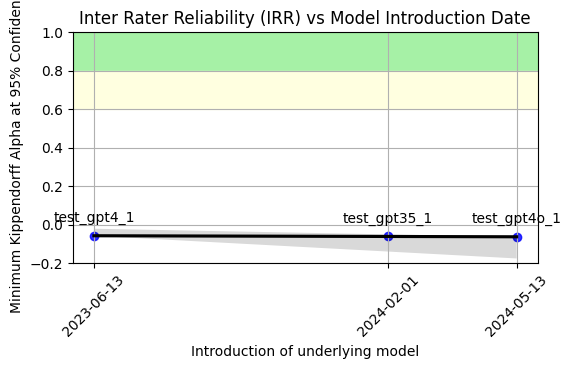

In [202]:
# Visualize Kippendorff 
name = name

# add relevant data to df from info_dict'
df = locals()[name]
df['introduction_date'] = df.index.map(lambda x: info_dict[x]['introduction_date'])

start_date = datetime(2023, 1, 1)
df['introduction_date_numeric'] = (df['introduction_date'] - start_date).dt.days

# Plotting
plt.figure(figsize=(6, 3))
sns.regplot(x='introduction_date_numeric', y='lb_ci_95_1s', data=df, scatter_kws={'color': 'blue'}, line_kws={'color': 'black'}) # , ci = None  to remove confidence interval
#plt.scatter(df['introduction_date'], df['lb_ci_95_1s'], color='blue')
plt.title('Inter Rater Reliability (IRR) vs Model Introduction Date')
plt.xlabel('Introduction of underlying model')
plt.ylabel('Minimum Kippendorff Alpha at 95% Confidence')
plt.grid(True)

plt.ylim(-0.2,1)
plt.axhspan(0.8, 1, color='lightgreen', alpha=0.8, label='reliable')
plt.axhspan(0.6, 0.8, color='lightyellow', alpha=1, label='tentative')
#plt.xlim(datetime(2023, 1, 1),datetime(2024, 7, 1))

# Annotate points with the model names
for idx, row in df.iterrows():
        plt.annotate(idx, (row['introduction_date_numeric'], row['lb_ci_95_1s']), textcoords="offset points", xytext=(0, 10), ha='center')

# Convert x-ticks back to datetime for readability
plt.xticks(
    ticks=df['introduction_date_numeric'],
    labels=df['introduction_date'].dt.strftime('%Y-%m-%d'),
    rotation=45
)


plt.show()

### Effect of Temperature on ICC

In [203]:
# Run Kippendorff Analysis
# Settings
name = 'kippendorff_H2' # Define Name
test_evaluators = filter_names(info_dict, model_type='test', model ='gpt4', temperature = None) # select evaluators for  test

# run analysis
locals()[name] = [['evaluator', 'alpha', 'c_reliable', 'c_tentative', 'c_unreliable', 'lb_ci_95_1s']] # initiate kippendorff

# iterate through test evaluators
for i, evaluator in enumerate(test_evaluators):
    data = agreement_table(evaluator)
    alpha, ci_95_2s, c_reliable, c_tentative, c_unreliable, lb_ci_95_1s = kippendorff_analysis(value_counts=data) # conduct analysis on value counts
    data = [evaluator, alpha, c_reliable, c_tentative, c_unreliable, lb_ci_95_1s]
    locals()[name].append(data)


# reformat into df
locals()[name] = pd.DataFrame(data=locals()[name][1:], columns=locals()[name][0]).set_index('evaluator').rename_axis(name, axis='columns')
locals()[name]

kippendorff_H2,alpha,c_reliable,c_tentative,c_unreliable,lb_ci_95_1s
evaluator,,,,,
test_gpt4_1,0.003294,0.0,0.0,1.0,-0.065179
test_gpt4_0,-0.021422,0.0,0.0,1.0,-0.091686


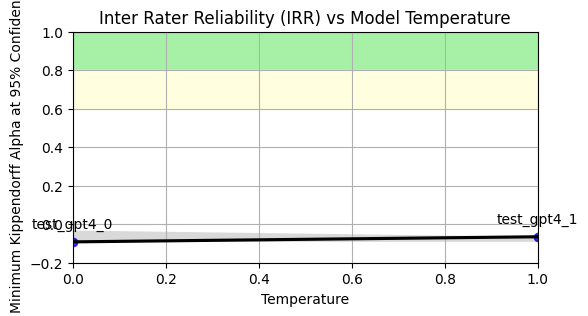

In [204]:
# Visualize Kippendorff 
name = name

# add relevant data to df from info_dict'
df = locals()[name]
df['temperature'] = df.index.map(lambda x: info_dict[x]['temperature'])


# Plotting
plt.figure(figsize=(6, 3))
sns.regplot(x='temperature', y='lb_ci_95_1s', data=df, scatter_kws={'color': 'blue'}, line_kws={'color': 'black'}) # , ci = None  to remove confidence interval
#plt.scatter(df['introduction_date'], df['lb_ci_95_1s'], color='blue')
plt.title('Inter Rater Reliability (IRR) vs Model Temperature')
plt.xlabel('Temperature')
plt.ylabel('Minimum Kippendorff Alpha at 95% Confidence')
plt.grid(True)

plt.ylim(-0.2,1)
plt.xlim(0, 1)
plt.axhspan(0.8, 1, color='lightgreen', alpha=0.8, label='reliable')
plt.axhspan(0.6, 0.8, color='lightyellow', alpha=1, label='tentative')

# Annotate points with the model names
for idx, row in df.iterrows():
        plt.annotate(idx, (row['temperature'], row['lb_ci_95_1s']), textcoords="offset points", xytext=(0, 10), ha='center')

plt.show()

###  Effect of Evaluator Type on ICC

In [207]:
# Run Kippendorff Analysis
# Settings
name = 'kippendorff_H3' # Define Name
test_evaluators = filter_names(info_dict, model_type=None, model ='gpt4', temperature = 1) # select evaluators for  test

# run analysis
locals()[name] = [['evaluator', 'alpha', 'c_reliable', 'c_tentative', 'c_unreliable', 'lb_ci_95_1s']] # initiate kippendorff

# iterate through test evaluators
for i, evaluator in enumerate(test_evaluators):
    data = agreement_table(evaluator)
    alpha, ci_95_2s, c_reliable, c_tentative, c_unreliable, lb_ci_95_1s = kippendorff_analysis(value_counts=data) # conduct analysis on value counts
    data = [evaluator, alpha, c_reliable, c_tentative, c_unreliable, lb_ci_95_1s]
    locals()[name].append(data)


# reformat into df
locals()[name] = pd.DataFrame(data=locals()[name][1:], columns=locals()[name][0]).set_index('evaluator').rename_axis(name, axis='columns')
locals()[name]

kippendorff_H3,alpha,c_reliable,c_tentative,c_unreliable,lb_ci_95_1s
evaluator,,,,,
test_gpt4_1,0.003294,0.0,0.0,1.0,-0.059026


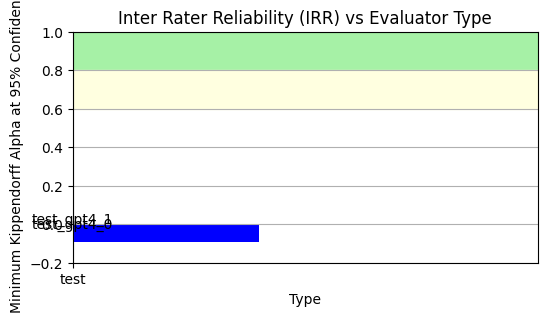

In [206]:
# Visualize Kippendorff  ##TODO:  Adapt barchart for pairwise comparison
name = name

# add relevant data to df from info_dict'
df = locals()[name]
df['type'] = df.index.map(lambda x: info_dict[x]['type'])


# Plotting
plt.figure(figsize=(6, 3))
#sns.regplot(x='temperature', y='lb_ci_95_1s', data=df, scatter_kws={'color': 'blue'}, line_kws={'color': 'black'}) # , ci = None  to remove confidence interval
plt.bar(df['type'], df['lb_ci_95_1s'], color='blue')
plt.title('Inter Rater Reliability (IRR) vs Evaluator Type')
plt.xlabel('Type')
plt.ylabel('Minimum Kippendorff Alpha at 95% Confidence')
plt.grid(True)

plt.ylim(-0.2,1)
plt.xlim(0, 1)
plt.axhspan(0.8, 1, color='lightgreen', alpha=0.8, label='reliable')
plt.axhspan(0.6, 0.8, color='lightyellow', alpha=1, label='tentative')

# Annotate points with the model names
for idx, row in df.iterrows():
        plt.annotate(idx, (row['type'], row['lb_ci_95_1s']), textcoords="offset points", xytext=(0, 10), ha='center')

plt.show()

### Score Consistency / Agreement
- Descriptive statistics
- Standard deviations per text --> analysis of texts with highest standard deviations
- Standard deviations and scatterplot per final 'true' score --> is there higher disagreement at certain scores?
- Krippendorfs alpha for disagreement of multiple raters
- Cronbachs Alpha to account for systematic variations --> ignoring systematic differences between different raters
- Alpha, Scott's pi, and Pearson's original intraclass correlation --> assuming interchangeable coders

- reliability vs validity of llm evaluators

In [23]:
vanilla_gpt4_1_scores

vanilla_gpt4_1_scores,1,2,3,4,5,mean,std,count,score
T,,,,,,,,,
1,0,0,9,1,0,3.1,0.32,10.0,3.0
2,0,7,3,0,0,2.3,0.48,10.0,2.0
3,0,1,9,0,0,2.9,0.32,10.0,3.0
4,0,9,1,0,0,2.1,0.32,10.0,2.0
5,0,2,8,0,0,2.8,0.42,10.0,3.0
6,8,2,0,0,0,1.2,0.42,10.0,1.0
7,8,2,0,0,0,1.2,0.42,10.0,1.0
8,0,8,2,0,0,2.2,0.42,10.0,2.0
9,4,5,0,1,0,1.8,0.92,10.0,2.0


In [ ]:
# kippendorff
kippendorff = [['evaluator', 'alpha', 'c_reliable', 'c_tentative', 'c_unreliable', 'lb_ci_95_1s']] # initiate kippendorff

# iterate through all evaluators
for i, evaluator in enumerate(evaluators): 
    alpha, ci_95_2s, c_reliable, c_tentative, c_unreliable, lb_ci_95_1s = kippendorff_analysis(value_counts=globals()[evaluator].select_dtypes(include='int')) # conduct analysis on value counts
    data = [evaluator, alpha, c_reliable, c_tentative, c_unreliable, lb_ci_95_1s]
    kippendorff.append(data)

# reformat into df
kippendorff = pd.DataFrame(data=kippendorff[1:], columns=kippendorff[0]).set_index('evaluator').rename_axis('kippendorff', axis='columns')
kippendorff

In [ ]:
# Visualize Kippendorff


# Sort by 'lb_ci_95_1s'
sorted_df = kippendorff.sort_values(by='lb_ci_95_1s')

plt.figure(figsize=(10, 6))

# Outline settings
plt.xlabel('Lower 95% confidence bound of Kippendorffs alpha')
plt.xlim(0,1)
plt.axvspan(0.6, 0.8, color='yellow', alpha=0.5, label='tentative')
plt.axvspan(0.8, 1, color='green', alpha=0.5, label='reliable')

# Plotting the horizontal bar chart
plt.barh(sorted_df.index, sorted_df['lb_ci_95_1s'], color='skyblue')

plt.ylabel('Evaluator')
plt.title('Inter Rater Reliability (IRR) of evaluators')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
text_data = concat.

In [ ]:
vanilla_GPT4o_1['mean'].var()

### Additional Analysies (optional)
- Time and Cost Analysis
- Characteristics Analysis
- Sentiment Analysis of reasons

## LLM Evaluations

### Vanilla_GPT3.5_0.0

In [ ]:
data_transposed = vanilla_GPT35_0_scores.transpose() # transpose data
fleiss_data = aggregate_raters(data_transposed, n_cat=5) # aggregate so that each column shows how often a score was given
fleiss_kappa(fleiss_data[0], method='fleiss') # calculate Fleiss' Kappa

### Human Evals

In [ ]:
# extract scores from qualtrics data --> qualtrics (at this point qualtrics contains all human scores and a boolean column indicating if the score is from an expert)
data_raw = pd.read_csv('Data/Qualtrics_Export.csv').drop([0, 1]).reset_index(drop=True).rename_axis('response')
drop_columns = ['StartDate', 'EndDate', 'Status', 'IPAddress', 'Progress', 'Duration (in seconds)', 'Finished', 'RecipientLastName', 'RecipientFirstName', 'RecipientEmail', 'ExternalReference', 'LocationLatitude', 'LocationLongitude', 'DistributionChannel', 'UserLanguage', 'Q_AmbiguousTextPresent', 'Q_AmbiguousTextQuestions', 'Q_StraightliningCount', 'Q_StraightliningPercentage', 'Q_StraightliningQuestions', 'Q_UnansweredPercentage', 'Q_UnansweredQuestions']
data_raw = data_raw.drop(columns=drop_columns)

# extract all fluff scores
qualtrics = data_raw.filter(regex='\.3$|Q2.1') # extract all third Subquestions which are the human fluff scores
question_nr = [int(x[1:-2]) for x in list(qualtrics.columns[1:])] # extract the question block numbers
text_nr = [str(x-2) for x in question_nr] # create the corresponding text numbers
qualtrics.columns = ['Expert'] + text_nr # rename columns
qualtrics = qualtrics.apply(pd.to_numeric, errors='coerce') # convert to numeric
qualtrics['Expert'] = qualtrics['Expert'].replace({1: False, 2: True}).astype(bool) # convert to boolean
qualtrics.rename_axis('qualtrics', axis='columns', inplace=True)

# delete helper data
del drop_columns
del question_nr
del text_nr
del data_raw

qualtrics

In [ ]:
# prepare human evaluations --> humans, experts, students
# prepare expert scores
students = qualtrics.loc[qualtrics['Expert'] == False].drop(columns='Expert').reset_index(drop=True) # subset for students and drop the expert column
students_stats = students.describe().transpose()[['mean', 'std', 'count']].round(2).rename_axis('T') # calculate stats for students
students_stats['score'] = students_stats['mean'].round(0) # create a score column
students_stats.index = students_stats.index.astype(int) # convert index to int
students = students.rename_axis('score').rename_axis('T', axis='columns') # rename axes
students = students.melt(value_name='score').dropna().reset_index(drop=True).astype(int).groupby(['T', 'score']).size().unstack(fill_value=0) # melt and groupby to get the counts of each score for each text
students = students.reindex(columns=[1,2,3,4,5], fill_value=0) # reindex to include all possible scores
students = students.merge(students_stats, left_index=True, right_index=True, how='left').rename_axis('students', axis='columns') # merge with the stats

# prepare expert scores
experts = qualtrics.loc[qualtrics['Expert'] == True].drop(columns='Expert').reset_index(drop=True) # subset for experts and drop the expert column
experts_stats = experts.describe().transpose()[['mean', 'std', 'count']].round(0).rename_axis('T') # calculate stats for experts
experts_stats['score'] = experts_stats['mean'].round(2) # create a score column
experts_stats.index = experts_stats.index.astype(int) # convert index to int
experts = experts.rename_axis('score').rename_axis('T', axis='columns') # rename axes
experts = experts.melt(value_name='score').dropna().reset_index(drop=True).astype(int).groupby(['T', 'score']).size().unstack(fill_value=0) # melt and groupby to get the counts of each score for each text
experts = experts.reindex(columns=[1,2,3,4,5], fill_value=0) # reindex to include all possible scores
experts = experts.merge(experts_stats, left_index=True, right_index=True, how='left').rename_axis('experts', axis='columns') # merge with the stats

# prepare human scores
humans = qualtrics.drop(columns='Expert').reset_index(drop=True) # subset for humans and drop the expert column
humans_stats = humans.describe().transpose()[['mean', 'std', 'count']].round(0).rename_axis('T') # calculate stats for humans
humans_stats['score'] = humans_stats['mean'].round(2) # create a score column
humans_stats.index = humans_stats.index.astype(int) # convert index to int
humans = humans.rename_axis('score').rename_axis('T', axis='columns') # rename axes
humans = humans.melt(value_name='score').dropna().reset_index(drop=True).astype(int).groupby(['T', 'score']).size().unstack(fill_value=0) # melt and groupby to get the counts of each score for each text
humans = humans.reindex(columns=[1,2,3,4,5], fill_value=0) # reindex to include all possible scores
humans = humans.merge(humans_stats, left_index=True, right_index=True, how='left').rename_axis('humans', axis='columns') # merge with the stats

# delete helperdata
del students_stats
del experts_stats
del humans_stats

students

### Score Correlation Analysis - Archive

In [ ]:
# visualize the scores
# Create a single set of axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot each score series as a line
text_data['Student Score'].plot(kind='line', ax=ax, label='Student Score', marker='o')
text_data['Expert Score'].plot(kind='line', ax=ax, label='Expert Score', marker='o')
# text_data['Vanilla_GPT3.5_0.0_score'].plot(kind='line', ax=ax, label='Vanilla_GPT3.5_0.0_score', marker='o')
text_data['Vanilla_GPT3.5_1.0_score'].plot(kind='line', ax=ax, label='Vanilla_GPT3.5_1.0_score', marker='o')
# text_data['Vanilla_GPT4o_1.0_score'].plot(kind='line', ax=ax, label='Vanilla_GPT4o_1.0_score', marker='o')


# Add title and labels
ax.set_title('Fluff Scores Comparison')
ax.set_xlabel('Text Number') 
ax.set_ylabel('Score')

# Ensure x-axis shows values from the T column
ax.set_xticks(range(len(text_data['T'])))
ax.set_xticklabels(text_data['T'])

# Add a legend to differentiate the lines
ax.legend()

# Show the plot
plt.show()


In [ ]:
# Score agreements using Cohen's Kappa
from sklearn.metrics import cohen_kappa_score

# calculate Cohen's Kappa between student and expert fluff scores
kappa_se = cohen_kappa_score(text_data['Student Score'], text_data['Expert Score'])
print(f'Cohen\'s Kappa between Student and Expert Scores: {kappa_se:.2f}')

# calculate Cohen's Kappa between student and Vanilla fluff scores
kappa_sv = cohen_kappa_score(text_data['Student Score'], text_data['Vanilla_GPT3.5_0.0_score'])
print(f'Cohen\'s Kappa between Student and Vanilla Scores: {kappa_sv:.2f}')

# calculate Cohen's Kappa between expert and Vanilla fluff scores
kappa_ev = cohen_kappa_score(text_data['Expert Score'], text_data['Vanilla_GPT3.5_0.0_score'])
print(f'Cohen\'s Kappa between Expert and Vanilla Scores: {kappa_ev:.2f}')



In [ ]:
# score agreements using Spearman's Rank Correlation
from scipy.stats import spearmanr

# calculate Spearman's Rank Correlation between student and expert fluff scores
spearman_se = spearmanr(text_data['Student Score'], text_data['Expert Score'])
print(f'Spearman\'s Rank Correlation between Student and Expert Scores: {spearman_se.correlation:.2f} with p-value: {spearman_se.pvalue:.2f}')

# calculate Spearman's Rank Correlation between student and Vanilla fluff scores
# spearman_sv = spearmanr(text_data['Student Score'], text_data['Vanilla_GPT3.5_0.0_score'])
# print(f'Spearman\'s Rank Correlation between Student and Vanilla Scores: {spearman_sv.correlation:.2f} with p-value: {spearman_sv.pvalue:.2f}')

# calculate Spearman's Rank Correlation between expert and Vanilla fluff scores
# spearman_ev = spearmanr(text_data['Expert Score'], text_data['Vanilla_GPT3.5_0.0_score'])
# print(f'Spearman\'s Rank Correlation between Expert and Vanilla_GPT3.5_0.0_score: {spearman_ev.correlation:.2f} with p-value: {spearman_ev.pvalue:.2f}')

# calculate Spearman's Rank Correlation between expert and Vanilla fluff scores
spearman_ev = spearmanr(text_data['Expert Score'], text_data['Vanilla_GPT3.5_1.0_score'])
print(f'Spearman\'s Rank Correlation between Expert and Vanilla_GPT3.5_1.0_score: {spearman_ev.correlation:.2f} with p-value: {spearman_ev.pvalue:.2f}')

# calculate Spearman's Rank Correlation between expert and Vanilla fluff scores
# spearman_ev = spearmanr(text_data['Expert Score'], text_data['Vanilla_GPT4o_1.0_score'])
# print(f'Spearman\'s Rank Correlation between Expert and Vanilla_GPT4o_1.0_score: {spearman_ev.correlation:.2f} with p-value: {spearman_ev.pvalue:.2f}')


In [ ]:
mse_ev = ((text_data['Vanilla_GPT3.5_1.0_score'] - text_data['Expert Score'])**2).mean()
print(f'Mean Squared Error between Expert and Vanilla_GPT3.5_1.0_score: {mse_ev:.2f}')

mae_ev = (text_data['Vanilla_GPT3.5_1.0_score'] - text_data['Expert Score'].abs()).mean()
print(f'Mean Absolute Error between Expert and Vanilla_GPT3.5_1.0_score: {mae_ev:.2f}')

In [ ]:
accuracy_ev = accuracy_score(text_data['Expert Score'], text_data['Vanilla_GPT3.5_1.0_score'].round())
print(f'Accuracy between Expert and Vanilla_GPT3.5_1.0_score: {accuracy_ev:.2f}')